In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
%%bash
ls prepared_data

Book3.xlsx
CMS2DRG_dic.pkd
CMS_dic.pkd
Inpatient.csv
Output_local_basis.csv
X_full.pkd
availability_size.png
cat_num_col.pkd
df_local.pkd
dic_num_to_DRG.pkd
est_1.pkd
est_2.pkd
est_3.pkd
est_4.pkd
hospitals.csv
list_DRG.pkd
nb_discharges_hosp.png
~$Book3.xlsx


# 1. Visualizations to explain the need to make predictions

Let's start focusing on the hospitals with the aggregated charges available (first column of our data). 

In [3]:
inpatients=pd.read_csv('prepared_data/Inpatient.csv')

Because the number of possible diagnostics is very important (more than 500), some diagnostics are only observed in a few number of hospitals. This is due to the fact that some medical conditions are less common than others in particular for Medicare patients (mainly people above 65) and also that the information on the prices is disclosed only if at least 10 Medicare patients' discharges have been observed at this hospital. As a consequence, the number of observed prices is very dependant on the relative size of the hospital. To show this effect, let's plot the number of observed prices compared to the total Medicare discharges at the hospital level.  

Let's build a new variable by hospitals: the number of Medicare discharges per hospital. 

In [4]:
first_graph=inpatients.groupby('prov_id').total_discharges.agg(['count','sum'])

In [5]:
%%bash
ls

Dockerfile
Models.ipynb
Visualizations.ipynb
app
prepared_data
raw_inputs


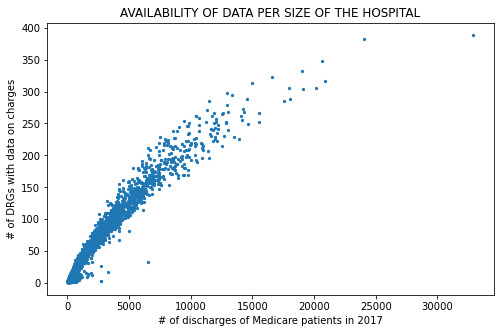

In [6]:
plt.figure(figsize=[8,5]);
plt.scatter(data=first_graph,x='sum',y='count',s=5);
plt.xlabel('# of discharges of Medicare patients in 2017');
plt.ylabel('# of DRGs with data on charges');
plt.title('AVAILABILITY OF DATA PER SIZE OF THE HOSPITAL');
plt.savefig('prepared_data/availability_size')

In [7]:
second_graph=inpatients.groupby('DRG').total_discharges.agg(['count','sum'])
second_graph.rename(columns={'count':'count_DRG','sum':'sum_DRG'},inplace=True)
second_graph['proportion_hospitals_DRG']=second_graph['count_DRG']/3182

Let's try to capture the effect of the 10 discharges threshold

In [8]:
enriched_inpatients=inpatients.merge(first_graph,left_on= 'prov_id', right_index=True)
enriched_inpatients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196325 entries, 0 to 196324
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   DRG                        196325 non-null  object 
 1   prov_id                    196325 non-null  int64  
 2   Provider State             196325 non-null  object 
 3   prov_zip                   196325 non-null  int64  
 4   total_discharges           196325 non-null  int64  
 5   average_covered_charges    196325 non-null  float64
 6   average_total_payments     196325 non-null  float64
 7   average_medicare_payments  196325 non-null  float64
 8   count                      196325 non-null  int64  
 9   sum                        196325 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 16.5+ MB


In [9]:
enriched_inpatients_2=enriched_inpatients.merge(second_graph, left_on='DRG',right_index=True)

In [10]:
list_DRG=[
    #'683 - RENAL FAILURE W CC',
    '871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV >96 HOURS W MCC',
    '392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS W/O MCC',
         '481 - HIP & FEMUR PROCEDURES EXCEPT MAJOR JOINT W CC',
         #'195 - SIMPLE PNEUMONIA & PLEURISY W/O CC/MCC',
         '243 - PERMANENT CARDIAC PACEMAKER IMPLANT W CC',
    '432 - CIRRHOSIS & ALCOHOLIC HEPATITIS W MCC',
    #'003 - ECMO OR TRACH W MV >96 HRS OR PDX EXC FACE, MOUTH & NECK W MAJ O.R.'
        ]

list_prov_id=inpatients.prov_id.drop_duplicates()[1:]

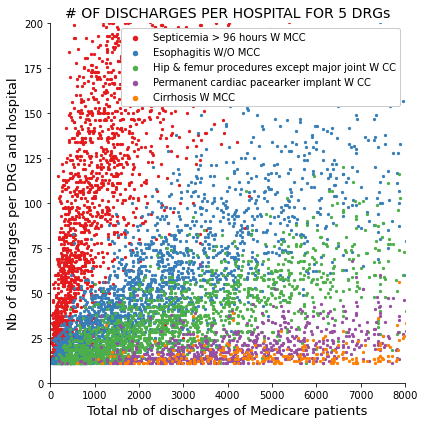

In [16]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
g=sb.FacetGrid(data=enriched_inpatients_2[enriched_inpatients_2.DRG.isin(list_DRG) & enriched_inpatients_2.prov_id.isin(list_prov_id)  ],
           hue='DRG',
               height=6,
               palette='Set1'
               , legend_out = True,
                hue_order=list_DRG
       )
g.map(plt.scatter,'sum','total_discharges',s=5,alpha=1)

plt.title("# OF DISCHARGES PER HOSPITAL FOR 5 DRGs",
         fontdict = {'fontsize': 14})
plt.xlabel('Total nb of discharges of Medicare patients',fontdict= {'fontsize': 13},)
plt.ylabel('Nb of discharges per DRG and hospital',fontdict= {'fontsize': 13},)
plt.xlim([0,8000])
plt.ylim([0,200])

plt.tight_layout()

new_labels = ['Septicemia > 96 hours W MCC',
                         'Esophagitis W/O MCC',
                         'Hip & femur procedures except major joint W CC',
              'Permanent cardiac pacearker implant W CC',
                         'Cirrhosis W MCC']

a=plt.legend(labels=new_labels,framealpha=1,markerscale=2) ;
a;

#for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

plt.savefig('nb_disc_DRG_hosp.png')


In [ ]:
#bUild the number of discharges per hospital and in the y axis the % of DRG that are described